# Casual inference, Synthetic Control and Sales analysis

The subsequent example showcases the application of causal analysis in marketing data, specifically employing the synthetic control methodology. The data utilized in this instance has been sourced from the open-source GitHub repository of 1749, available at https://github.com/nialloulton/1749/blob/main/CausalPy/CausalPy%20Synthetic%20Control.ipynb. For further insights, readers are encouraged to explore the associated blog post at https://1749.io/resource-center/f/quantifying-retail-media-impact-with-causalpy-causal-inference?blogcategory=Marketing, authored by 1749, who adeptly employed the user-friendly CausalPy API to illustrate this type of analysis. While emphasizing the commendable goal of simplicity, this path may obscure some nuances for potential analysts, impeding a deeper understanding of the method's utility.

To credit 1749's emphasis on ease of use, this notebook aims to be a valauable addition by employing the Stan language to replicate the Bayesian analysis previously demonstrated by 1749. The replication aims to provide the reader or analyst with a more comprehensive understanding of the statistical model and methodology. Ultimately, this enhanced comprehension contributes to recognizing the value of synthetic control in addressing real-world marketing analysis problems and analogous analytical challenges that require causal inference through a simulated example. Moreover, this analysis illuminates additional facets of the full Bayesian workflow not covered in the blog post at https://1749.io/resource-center/f/quantifying-retail-media-impact-with-causalpy-causal-inference?blogcategory=Marketing. Which to 1749 credit was not his aim.

# What is Synthetic control

The following description is based on my reading of two sources Alves(2022) and Cunnigham (2021). Highly recommend both resources fro their style and lucid presentation.

Synthetic control is an incredibly effective methodology built on top of a very simple idea. The method aims to calculate the treatment effect through what is known as comparative case studies (CCS). CCS are often forms of causal designs bassed on natrual experiements.

# The data

The dataset presented below simulates sales data for a range of Samsung products, including the Pixel and Galaxy series phones, laptops, and more. The data covers a two-year period from 2021 to 2023. The introduction of these products onto the market is simulated to occur gradually throughout 2021. The sales patterns of the products follow stages. These stages are introduction, growth, maturity, and decline over time. Seasonal affects (holiday seasons) are also present within the sales data. With increase peaks of 50% in December, Janaury and July. The final simulated aspect, which is critcal to the present anlaysis is the inclusion of media campaign for 'Pixelophone XL'. That within the simulation results in large spike in sales for that product between January and July of 2023. This is the foucs of our modelling 

The meticulous detailing in this simulation, crafted by '1749', mirrors the real-life product life cycle observed in the efforts of companies to optimize sales. This high level of simulation granularity enables the expression of causal thinking in data modeling, leading to more precise inferences about marketing and sales strategies.

In [8]:
# Import python modules for analysis.
import pandas as pd
import stan as ps
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
from plot_utils import plotcampaign, plot_xY


# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply()

In [9]:
#Url for github where dataset the is stored
url = 'https://raw.githubusercontent.com/HPCurtis/Datasets/main/1749.csv'
full_df = pd.read_csv(url)

# Convert the 'Date' column to datetime format
full_df['Date'] = pd.to_datetime(full_df['Date'])
campaign_start = pd.Timestamp('2023-01-01')
campaign_end = pd.Timestamp('2023-06-30')

# Filter out only the Pixelophone_XL data and other control products data
pixelophone_xl_data = full_df[full_df['Product'] == 'Pixelophone_XL'].set_index('Date')
other_products_data = full_df[full_df['Product'] != 'Pixelophone_XL'].pivot(index='Date', columns='Product', values='Sales')

other_products_data

# Combine the two DataFrames
combined_data = pd.concat([pixelophone_xl_data['Sales'], other_products_data], axis=1).fillna(0)
combined_data.shape
# Rename the 'Sales' column to 'Pixelophone_XL'
combined_data = combined_data.rename(columns={'Sales': 'Pixelophone_XL'})

# Convert to pre and post media campaign dataframes
combined_data_pre = combined_data[combined_data.index <= campaign_start]
combined_data_post =  combined_data[combined_data.index > campaign_start]

# Generate pre and post campaign data tha can be passed to stan
y_pre = combined_data_pre['Pixelophone_XL'].values
X_pre = combined_data_pre.loc[:, combined_data.columns != 'Pixelophone_XL'].values
y_post = combined_data_post['Pixelophone_XL'].values
X_post = combined_data_post.loc[:, combined_data.columns != 'Pixelophone_XL'].values

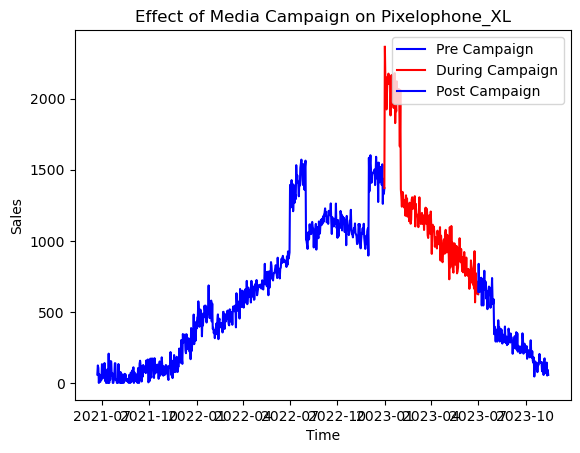

In [10]:
plotcampaign(full_df=full_df)

# Stan model for Sythentic contol

The following model is a Stan implementation of the CausalPy model (see, https://github.com/pymc-labs/CausalPy/blob/main/causalpy/pymc_models.py). 


In [11]:
stanSynthticControl = ''' 
data{
// number of varaibles and parameters pre and post.
int N_pre;
int N_post;
int K;

vector[N_pre]  y_pre;
matrix[N_pre, K] X_pre;

vector[N_post]  y_post;
matrix[N_post, K] X_post;

// Priro value for sd of sigma parameter
real sdS;

}
parameters{
simplex[K] beta;
real<lower = 0> sigma; 
}

transformed parameters{
vector[N_pre] mu_pre;
mu_pre = X_pre * beta;
}

model{
// Priors 
sigma ~ normal(0, sdS);

// Uniform default prior
beta ~ dirichlet( rep_vector(1, K) );

// Likelihood
y_pre ~ normal(mu_pre, sigma);
}

generated quantities{
// Posterior predicitive checks
// Model fit assessment
array[N_pre] real yrep;
yrep = normal_rng(mu_pre, sigma);

// Post intervention prediction
vector[N_post] mu_post;
mu_post = X_post * beta;
array[N_post] real yPostPred;
yPostPred = normal_rng(mu_post, sigma);

// Calculate causal impact 
vector[N_pre] pre_impact = y_pre - mu_pre;
vector[N_post] post_impact = y_post - mu_post;
vector[N_post] post_impact_cumulative = cumulative_sum(post_impact);
}
'''

In [12]:
# Generate python dictionary to pass to stan. 
data = {'N_pre': len(y_pre),
        'N_post': len(y_post),
        'K': X_pre.shape[1],
        'y_pre': y_pre,
        'X_pre': X_pre,
        'y_post': y_post,
        'X_post': X_post,        
        'sdS': 1
        }

# Compile stan model to C++.
sm = ps.build(stanSynthticControl,data= data);

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [13]:
# Fit stan model to data.
fit = sm.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   5% (403/8000)
Sampling:  30% (2402/8000)
Sampling:  55% (4401/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 6.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
  Adjust your expectations accordingly!


In [14]:
idata = az.from_pystan(posterior=fit, posterior_model=sm, 
                       posterior_predictive=['yrep'], observed_data=  ['y_pre']) 

In [15]:
# Output results of the model fit.
print(az.summary(fit, var_names= ['beta', 'sigma'], round_to=2))

# Calculate Bayesian r_squared.
# Notice that this all about model fit so its about the pre data.
Br2 = az.r2_score(y_true= y_pre, y_pred=fit['yrep'].T)
print('Bayesian R sqaured', Br2[0])

          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]   0.21  0.01    0.19     0.24       0.00     0.00   2725.44   2989.67   
beta[1]   0.00  0.00    0.00     0.01       0.00     0.00   3062.92   2120.45   
beta[2]   0.00  0.00    0.00     0.01       0.00     0.00   3190.13   1909.63   
beta[3]   0.00  0.00    0.00     0.01       0.00     0.00   2846.40   1377.87   
beta[4]   0.69  0.02    0.65     0.72       0.00     0.00   4189.41   2849.83   
beta[5]   0.00  0.00    0.00     0.01       0.00     0.00   3232.31   1928.64   
beta[6]   0.03  0.01    0.02     0.04       0.00     0.00   3988.17   3139.61   
beta[7]   0.00  0.00    0.00     0.00       0.00     0.00   3118.46   1742.94   
beta[8]   0.05  0.02    0.02     0.08       0.00     0.00   2454.50   1352.95   
sigma    44.78  0.46   43.88    45.63       0.01     0.01   4178.02   3012.67   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
beta[2]    1.0  
beta[3]    1.0  
beta[4]    1.0  
beta[5

# Plot model results

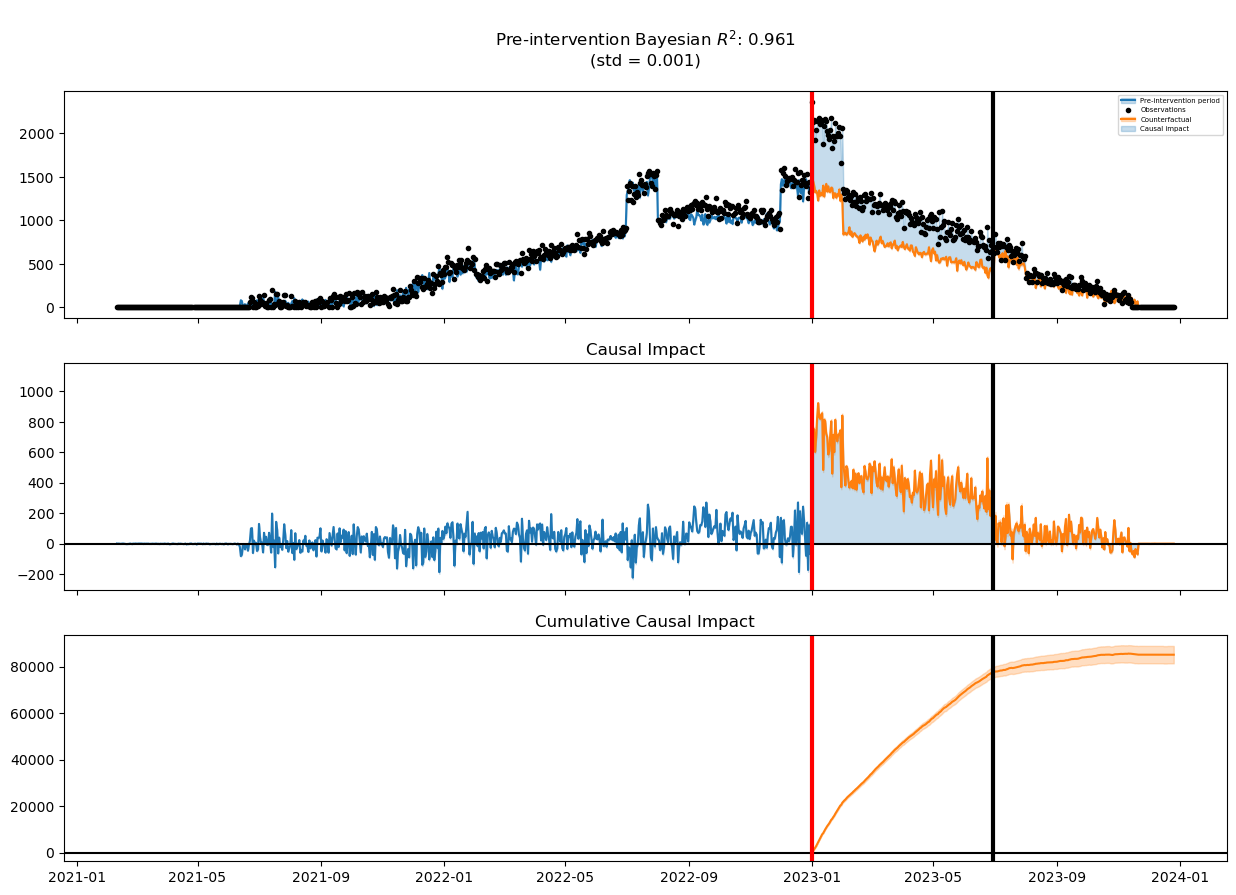

In [18]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 8))
 
h_line, h_patch = plot_xY(combined_data_pre.index, idata.posterior.mu_pre, ax = ax[0],plot_hdi_kwargs={"color": "C0"});

handles = [(h_line, h_patch)]
labels = ["Pre-intervention period"]

(h,) = ax[0].plot(combined_data_pre.index, y_pre, "k.", label="Observations")
handles.append(h)
labels.append("Observations")

h_line, h_patch = plot_xY(
combined_data_post.index,
idata.posterior.mu_post,
ax=ax[0],
plot_hdi_kwargs={"color": "C1"},
)
handles.append((h_line, h_patch))
labels.append("Counterfactual")

ax[0].plot(combined_data_post.index, y_post, "k.")
# Shaded causal effect
h = ax[0].fill_between(
combined_data_post.index,
y1=az.extract(idata, group='posterior', var_names='mu_post').mean("sample"),
y2=np.squeeze(y_post),
color="C0",
alpha=0.25,
)
handles.append(h)
labels.append("Causal impact")

ax[0].set(
title=f"""
Pre-intervention Bayesian $R^2$: {Br2[0]:.3f}
(std = {Br2[1]:.3f})
""")

 # MIDDLE PLOT -----------------------------------------------
plot_xY(combined_data_pre.index,
         idata['posterior'].pre_impact, 
         ax = ax[1],
         plot_hdi_kwargs={"color": "C0"}
)
plot_xY(
    combined_data_post.index,
    idata['posterior'].post_impact,
    ax=ax[1],
    plot_hdi_kwargs={"color": "C1"},
)
ax[1].axhline(y=0, c="k")
ax[1].fill_between(
    combined_data_post.index,
    y1=idata['posterior'].post_impact.mean(["chain", "draw"]),
    color="C0",
    alpha=0.25,
    label="Causal impact",
)
ax[1].set(title="Causal Impact")

# BOTTOM PLOT -----------------------------------------------
ax[2].set(title="Cumulative Causal Impact")
plot_xY(
        combined_data_post.index,
    idata['posterior'].post_impact_cumulative,
    ax=ax[2],
    plot_hdi_kwargs={"color": "C1"},
)
ax[2].axhline(y=0, c="k")

# Intervention line
for i in [0, 1, 2]:
    ax[i].axvline(
        x = campaign_start,
        ls="-",
        lw=3,
        color="r",
    )
    ax[i].axvline(
        x = campaign_end,
        ls="-",
        lw=3,
        color="k",
    )

ax[0].legend(
    handles=(h_tuple for h_tuple in handles),
    labels=labels,
    fontsize=5,
)

# Set the size of the current figure
plt.gcf().set_size_inches(15, 10)


# Media campaigns impact on Sales 

From the preceding analysis we can say that the implemenation of the media marketing campaign through Janauary to end of June of 2023 resulted in an accumulated increase of around 80000 additonal sales of the 'Pixelophone_XL' product as shown by the cumualative causal impact plot. 

# Posterior predicitve checks

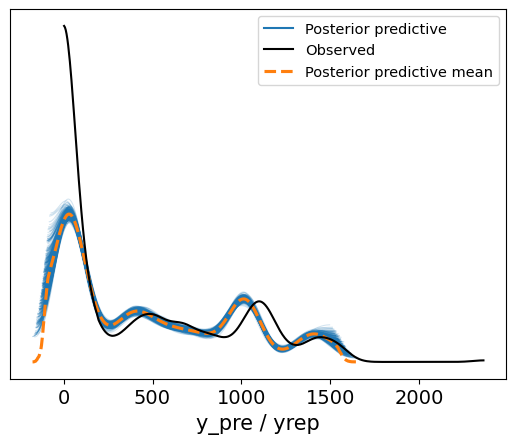

In [19]:
az.plot_ppc(data = idata, data_pairs = {'y_pre': 'yrep'}, num_pp_samples = 500);

# References
 Alves, F, M. Causal inference for the brave and true. Github.

 Cunnigham, S. Cuasal Mixtape. Yale University Press.